## Goals for this exercise
1. Implement MC 
2. Implement TD(0)
3. Implement TD(lambda)

In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

Implement every-visit MC

* Loop through episodes
* Write function G that given a full episode of an episode, returns returns for each intermediate state
* Use G to keep count of return and sums

In [8]:
# DEV
observation = env.reset()
observation
a = env.step(1)
print(a)

((21, 10, False), 0, False, {})


## First implement MC

In [65]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    # Implement this!
                  
    # Loop through episodes. Construct lists 1) obervations 2) rewards
    for i_episode in range(num_episodes):
        observation, done = env.reset(), False
        observation_hist = [observation]
        reward_hist = []            
        while not done:
            action = np.random.choice([0,1], p = policy(observation))
            observation, reward, done, _ = env.step(action)
            observation_hist.append(observation)
            reward_hist.append(reward)
        # Go through this episode history, calculate the total rewards for all intermediate states
        episode_length = len(reward_hist)
        for i in range(episode_length):
            observation = observation_hist[i]
            total_reward = 0
            for j in range(episode_length - i):
                total_reward += np.power(discount_factor, j) * reward_hist[i + j]
            returns_count[observation] += 1
            returns_sum[observation] += total_reward
    # Calulate V
    for observation in returns_count:
        V[observation] = returns_sum[observation] / returns_count[observation]
    
    return V    

In [4]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return np.array([1.0, 0.0]) if score >= 20 else np.array([0.0, 1.0])

In [5]:
# A slightly less dumb policy
def sample_policy2(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return np.array([1.0, 0.0]) if score >= 17 else np.array([0.0, 1.0])

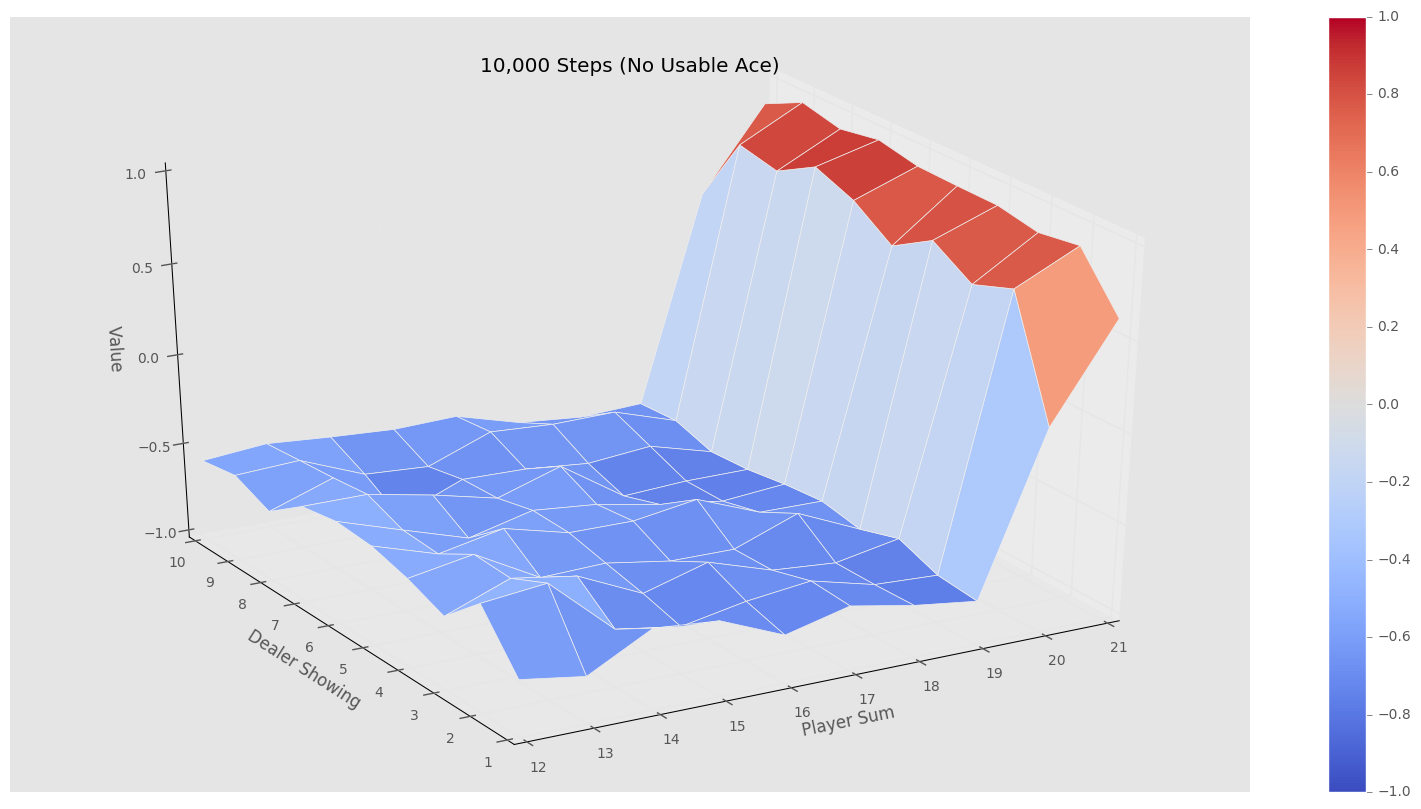

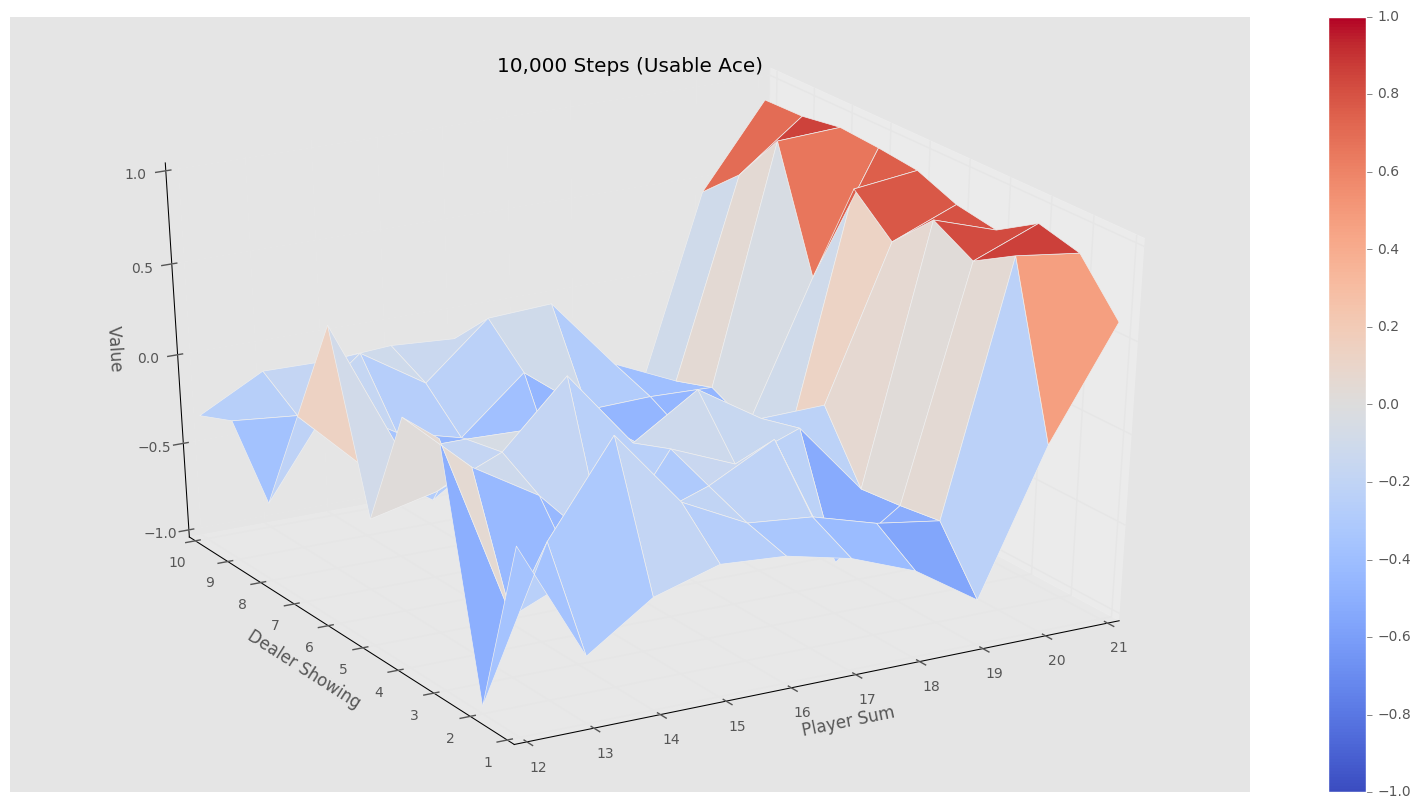

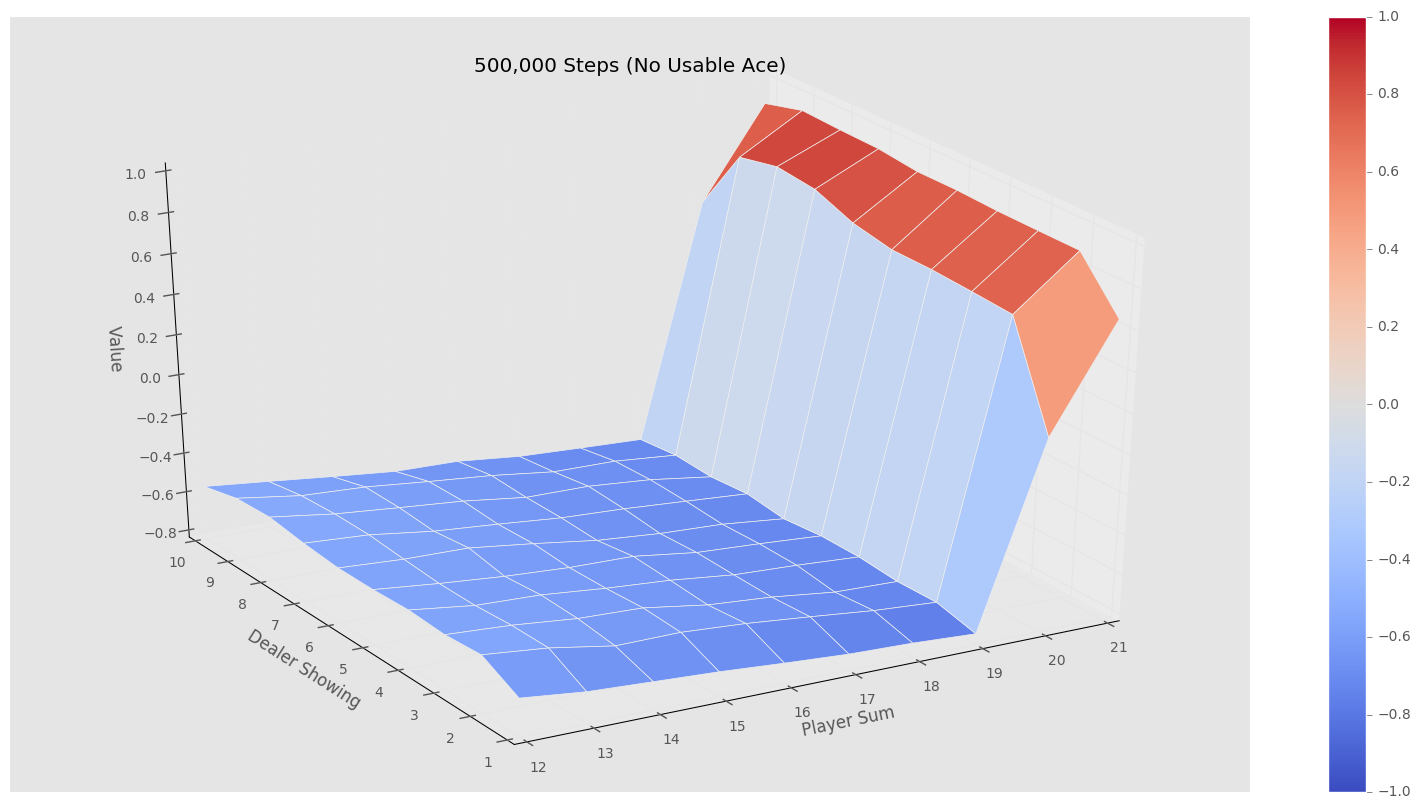

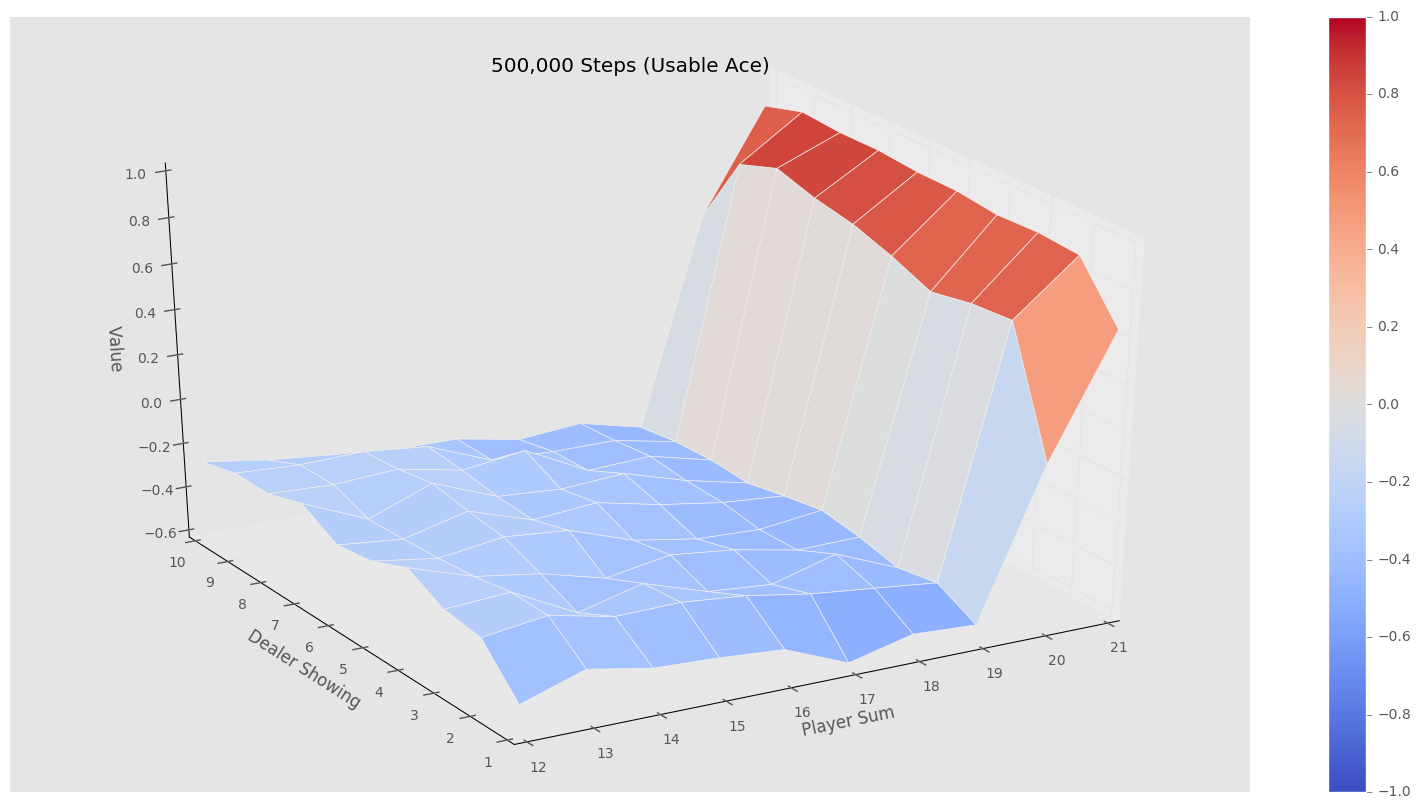

In [68]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")

__Success!__

## Now implement TD(0)

In [104]:
def td_prediction(policy, env, num_episodes, discount_factor=1.0, alpha=0.5, decay_step=1000, decay_rate = 1.0):
    """
    Temporal Difference prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """    
    # The final value function 
    V = defaultdict(float)
    
    # Implement this!
    for i_episode in range(num_episodes):
        if i_episode % decay_step == 0:
            alpha = alpha * decay_rate
        observation = env.reset()
        done = False
        while not done:
            action = np.random.choice([0,1], p = policy(observation))
            next_observation, reward, done, _ = env.step(action)
            # In the env design, if stick at 21 done then state -> state with reward ~ 1, creating infinite
            # increasing value functions...in reality this is not the same state, hence treating the termination
            # state seperately
            if done:
                td_delta = alpha * (reward + discount_factor * 0 - V[observation])
            # Avoid creating V[s] for player sum > 21, so that the plots are consistent with previous
            elif next_observation[0] >= 21:
                td_delta = alpha * (reward + discount_factor * 0 - V[observation])  
            else:
                td_delta = alpha * (reward + discount_factor * V[next_observation] - V[observation])
            V[observation] += td_delta
            observation = next_observation
    return V    

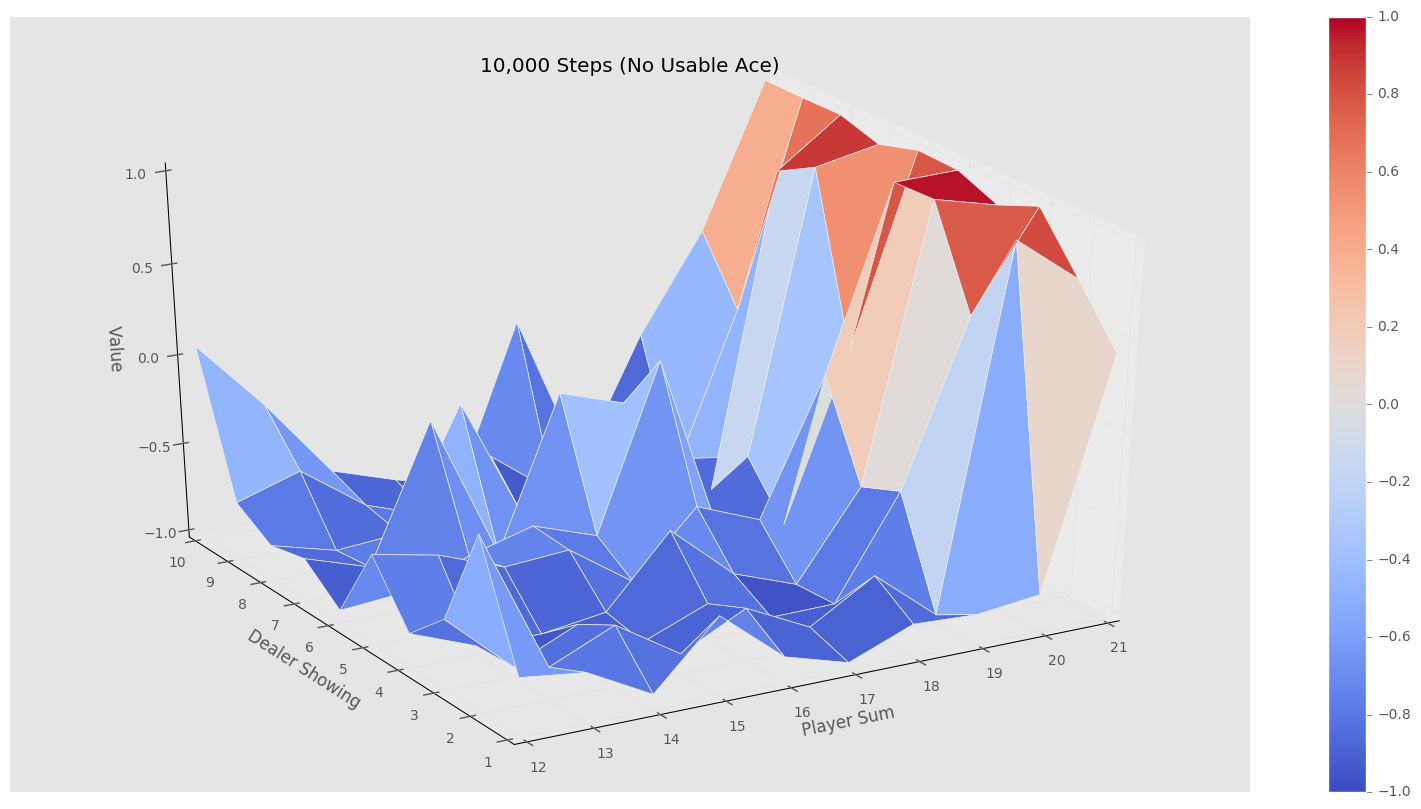

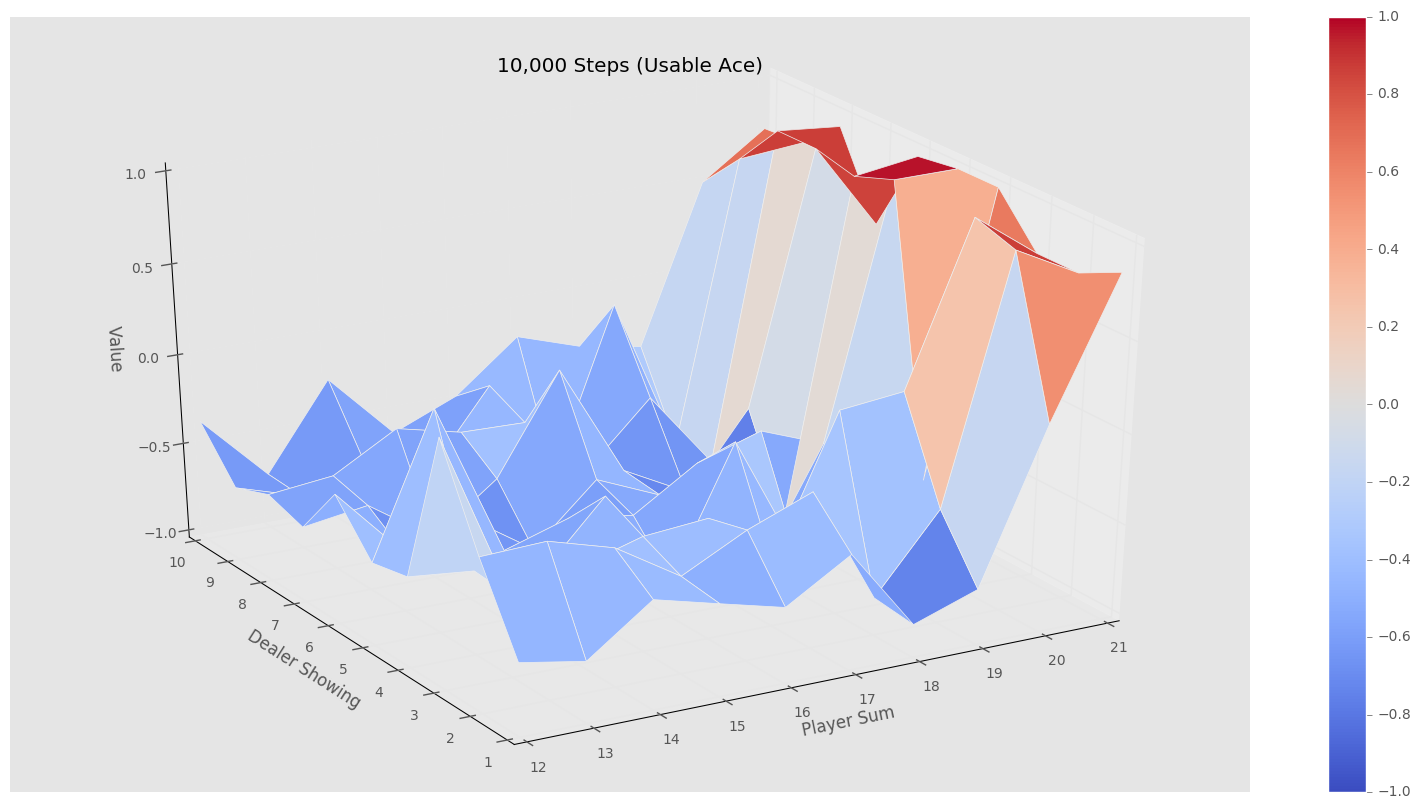

In [95]:
V_10k = td_prediction(sample_policy, env, num_episodes=10000, alpha=0.5)
plotting.plot_value_function(V_10k, title="10,000 Steps")

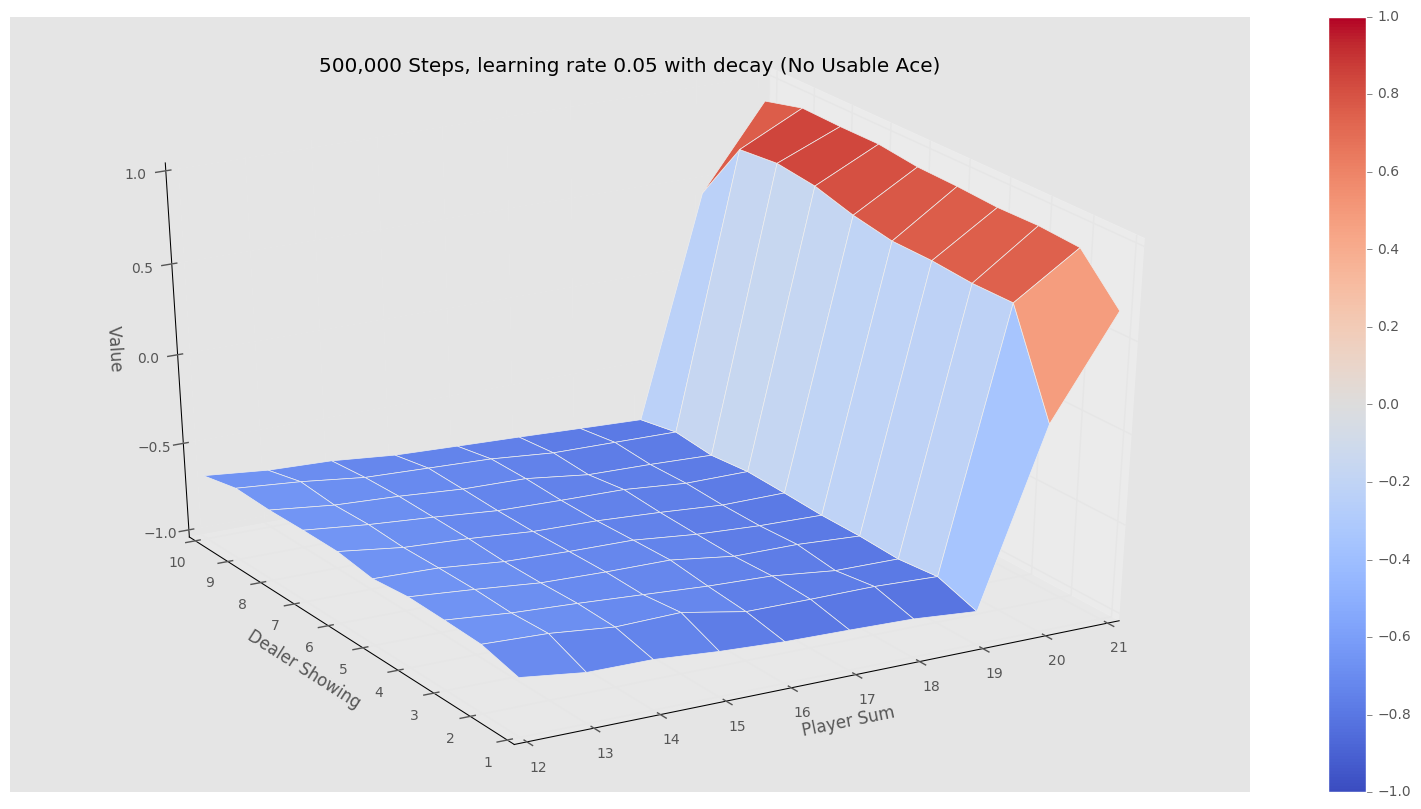

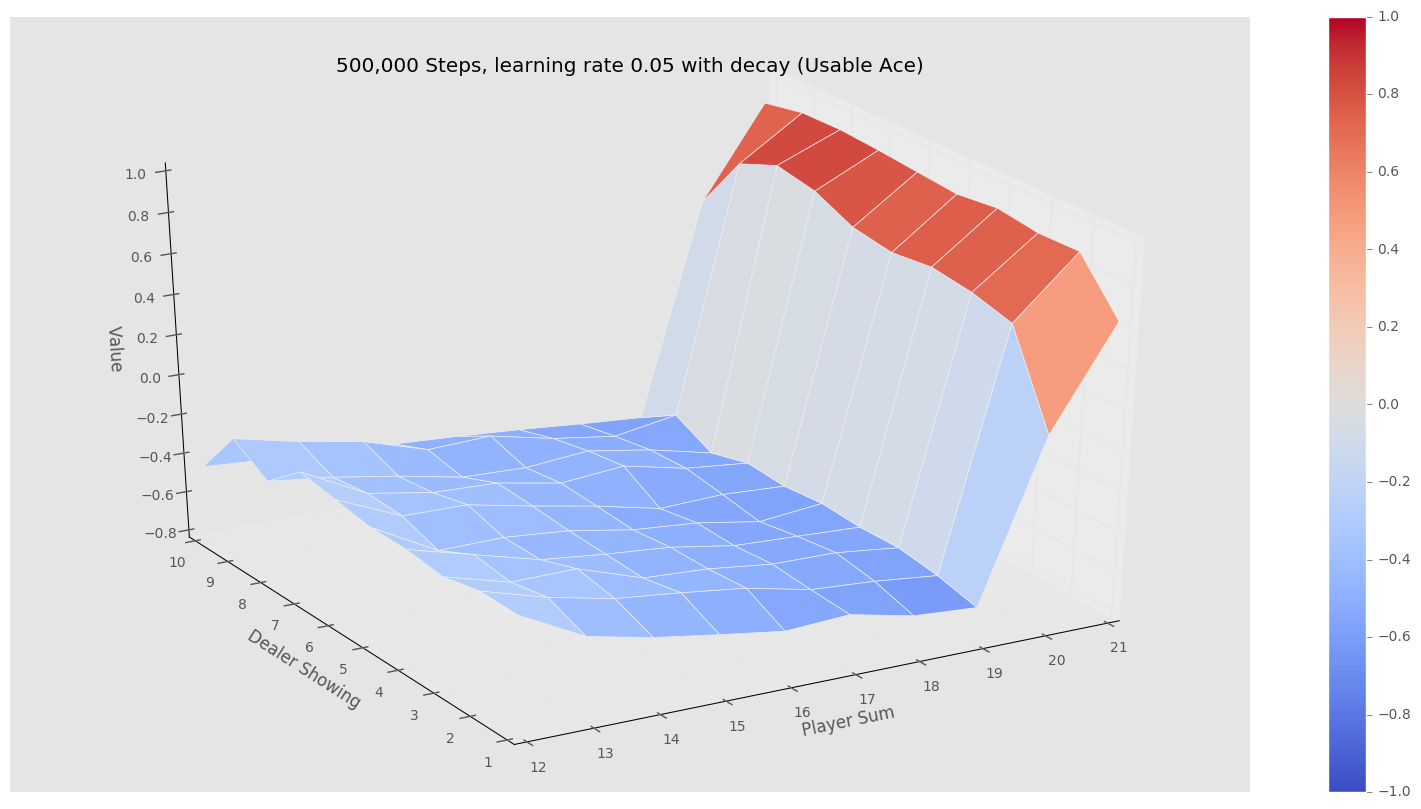

In [107]:
V_500k = td_prediction(sample_policy, env, num_episodes=500000, alpha=0.05, decay_rate = 0.98)
plotting.plot_value_function(V_500k, title="500,000 Steps, learning rate 0.05 with decay")

### Finally made TD converge after correcting for terminating state. 
* Small learning rate seems important
* However the end result still seems worse than MC. Why?
    * -> I suspect learning rate decay will be necessary.
    * Adding learning rate decay makes the result surface a lot smoother. (But is it more correct?)

## Implement online backward-view TD(lambda)
* Loop through episodes
* Keep eligibility trace E
* For every step:
    * Update eligibility trace E (for all states)
    * Update V for s using eligibility trace E

In [3]:
def td_lambda_prediction(policy, env, num_episodes, discount_factor=1.0, alpha=0.5, l=0.9,
                        decay_step=1000, decay_rate = 1.0):
    """
    Temporal Difference lambda prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """    
    # The final value function 
    V = defaultdict(float)
    
    # Implement this!
    for i_episode in range(num_episodes):
        # Decay learning rate
        if i_episode % decay_step == 0:
            alpha = alpha * decay_rate
        # Intialization env
        observation, done = env.reset(), False
        E = defaultdict(float)
        while not done:
            action = np.random.choice([0,1], p = policy(observation))
            next_observation, reward, done, _ = env.step(action)
            # Generate td_delta
            if done:
                td_delta = reward + discount_factor * 0 - V[observation]
            elif next_observation[0] >= 21:
                td_delta = reward + discount_factor * 0 - V[observation]
            else:
                td_delta = reward + discount_factor * V[next_observation] - V[observation]
            # Update eligibility trace E for all states
            for state in E:
                E[state] = E[state] * l
            E[observation] += 1
            for state in E:
                V[state] += alpha * E[state] * td_delta
            # Apply update
            observation = next_observation
    return V    

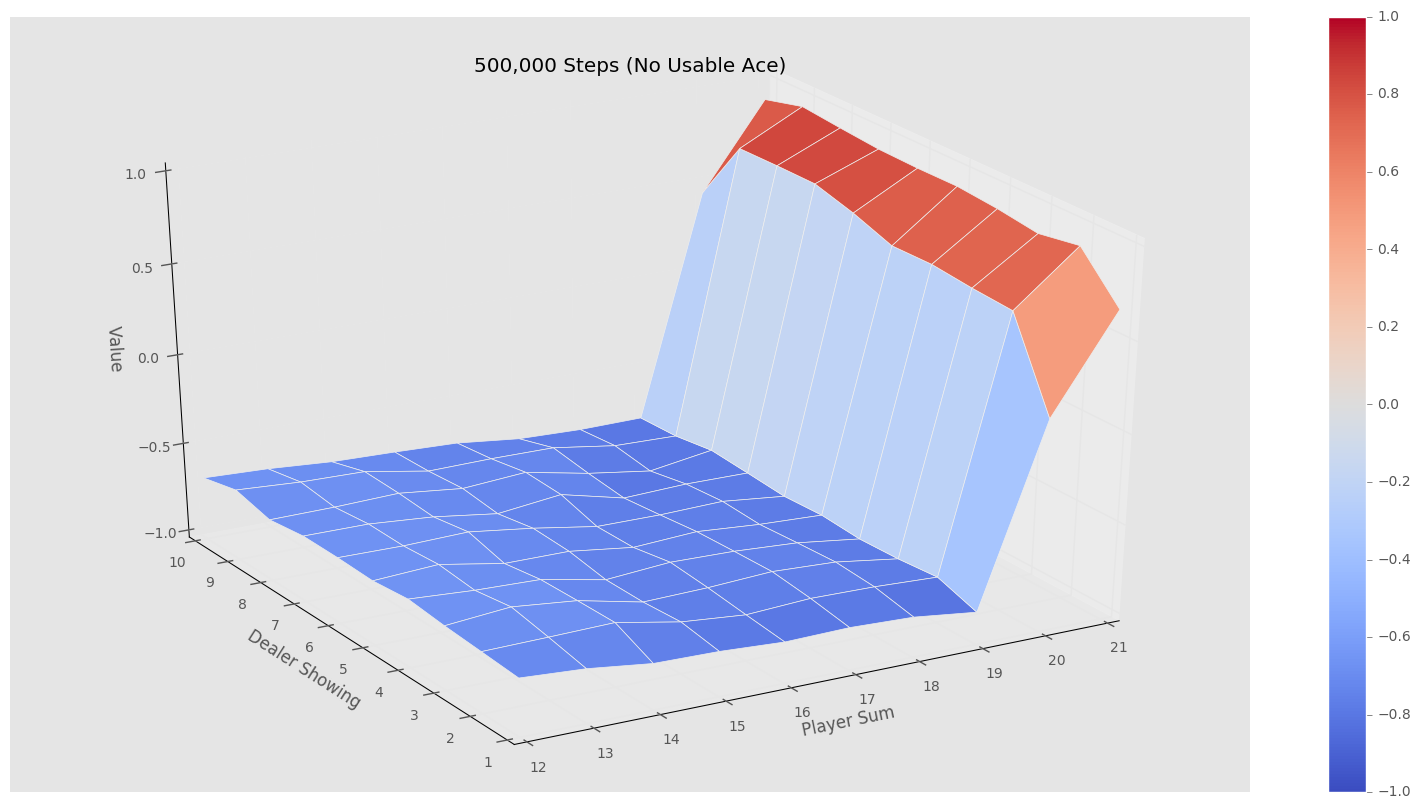

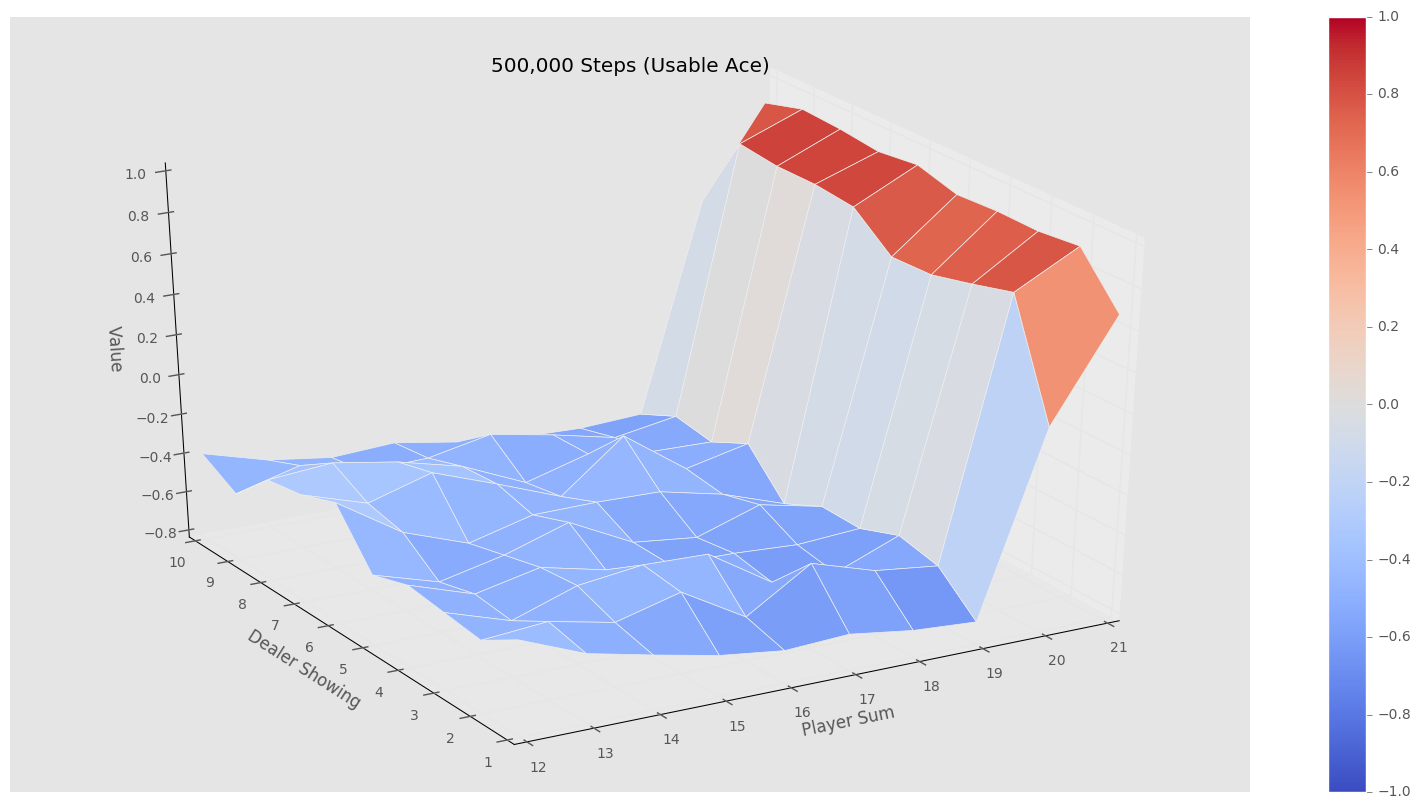

In [7]:
V_500k = td_lambda_prediction(sample_policy, env, num_episodes=10000, alpha=0.3, decay_rate = 0.95)
plotting.plot_value_function(V_500k, title="500,000 Steps")